In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm



In [6]:
# move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# for data_batch, labels_batch in train_loader:
#     data_batch = data_batch.to(device)
#     labels_batch = labels_batch.to(device)
#     print(f"Data batch size: {data_batch.shape}, Labels batch size: {labels_batch.shape}")
#     break

Using device: cuda


Create the DL model

In [ ]:
def createTheNet(printtoggle=False):

  class cnnNet(nn.Module):
    def __init__(self, printtoggle):
      super().__init__()

      # 3x3 conv stack
      self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)   # [B,32,128,128]
      self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # [B,64,64,64]
      self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1) # [B,128,32,32]

      self.pool = nn.MaxPool2d(2, 2)  # 每次减半尺寸

      # 全连接层（128 * 16 * 16 = 32768，如果用3次pooling）
      self.fc1 = nn.Linear(128 * 16 * 16, 256)
      self.out = nn.Linear(256, 2)

      self.dropout = nn.Dropout(p=0.5)
      self.print = printtoggle

    def forward(self, x):
      if self.print: print(f'Input: {x.shape}')

      x = self.pool(F.relu(self.conv1(x)))
      if self.print: print(f'After conv1+pool: {x.shape}')

      x = self.pool(F.relu(self.conv2(x)))
      if self.print: print(f'After conv2+pool: {x.shape}')

      x = self.pool(F.relu(self.conv3(x)))
      if self.print: print(f'After conv3+pool: {x.shape}')

      x = x.view(x.size(0), -1)
      if self.print: print(f'Flatten: {x.shape}')

      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = self.out(x)
      return x

  net = cnnNet(printtoggle)
  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

  return net, lossfun, optimizer


In [8]:
# save 10times results
numepochs = 50
sum_trainAcc = np.zeros(numepochs)
sum_testAcc  = np.zeros(numepochs)
sum_losses   = np.zeros(numepochs)

# load dataset
data_path = 'D:\\McMaster\\769 project P2\\fruit\\code\\fruit_dataset_padded_128.pt'
dataset = torch.load(data_path)

data = dataset['data']
labels = dataset['labels']

dataT = data.float()
labelsT = labels.long()

# split dataset into train and test sets
train_data, test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.2)

# convert into PyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data  = TensorDataset(test_data, test_labels)

# translate into dataloader objects
batch_size    = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

augment_combo = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.GaussianBlur(kernel_size=3),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

def function2trainTheModel():      
    # create a new model
    net,lossfun,optimizer = createTheNet()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)


    # initialize losses
    losses    = torch.zeros(numepochs)
    trainAcc  = []
    testAcc   = []

    # loop over epochs
    for epochi in range(numepochs):
        loop = tqdm(train_loader, desc=f'Epoch {epochi+1}/{numepochs}', leave=False)
        # loop over training data batches
        net.train()
        batchAcc  = []
        batchLoss = []
        for X,y in train_loader:
            # 对每一张图应用 transforms
            X = torch.stack([augment_combo(img.cpu()) for img in X])
            X, y = X.to(device), y.to(device)

            y = torch.squeeze(y)
            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
            matchesNumeric = matches.float()             # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
            batchAcc.append( accuracyPct )               # add to list of accuracies
            # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( torch.tensor(batchAcc).mean().item() )
        # and get average losses across the batches
        losses[epochi] = torch.tensor(batchLoss).mean().item()
        if (epochi + 1) % 5 == 0:
            torch.save(net.state_dict(), f"fruit_model_epoch{epochi+1:02d}.pth")
            print(f"✅ 模型已保存: fruit_model_epoch{epochi+1:02d}.pth")
        # test accuracy
        net.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        X, y = X.to(device), y.to(device)
        with torch.no_grad(): # deactivates autograd
            yHat = net(X)
            y = torch.squeeze(y)
        # compare the following really long line of code to the training accuracy lines
        testAcc.append(100 * (torch.argmax(yHat, axis=1) == y).float().mean().item())
        

        # function output
    return trainAcc,testAcc,losses,net

trainAcc,testAcc,losses,net = function2trainTheModel()

    # sum_trainAcc += np.array(trainAcc) / 10
    # sum_testAcc  += np.array(testAcc) / 10
    # sum_losses   += losses.numpy() / 10


C:\Users\qiuqi\AppData\Local\Temp\ipykernel_16740\1081143235.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(data_path)
Epoch 5/50:   0%|          |

✅ 模型已保存: fruit_model_epoch05.pth


✅ 模型已保存: fruit_model_epoch10.pth


Epoch 15/50:   0%|          | 0/419 [00:00<?, ?it/s]

✅ 模型已保存: fruit_model_epoch15.pth


✅ 模型已保存: fruit_model_epoch20.pth


Epoch 25/50:   0%|          | 0/419 [00:00<?, ?it/s]

✅ 模型已保存: fruit_model_epoch25.pth


✅ 模型已保存: fruit_model_epoch30.pth


Epoch 35/50:   0%|          | 0/419 [00:00<?, ?it/s]

✅ 模型已保存: fruit_model_epoch35.pth


✅ 模型已保存: fruit_model_epoch40.pth


Epoch 45/50:   0%|          | 0/419 [00:00<?, ?it/s]

✅ 模型已保存: fruit_model_epoch45.pth


✅ 模型已保存: fruit_model_epoch50.pth


In [9]:
torch.save(net.state_dict(), "fruit_model1.pth")
print("✅ 模型已保存为 fruit_model.pth")


✅ 模型已保存为 fruit_model.pth


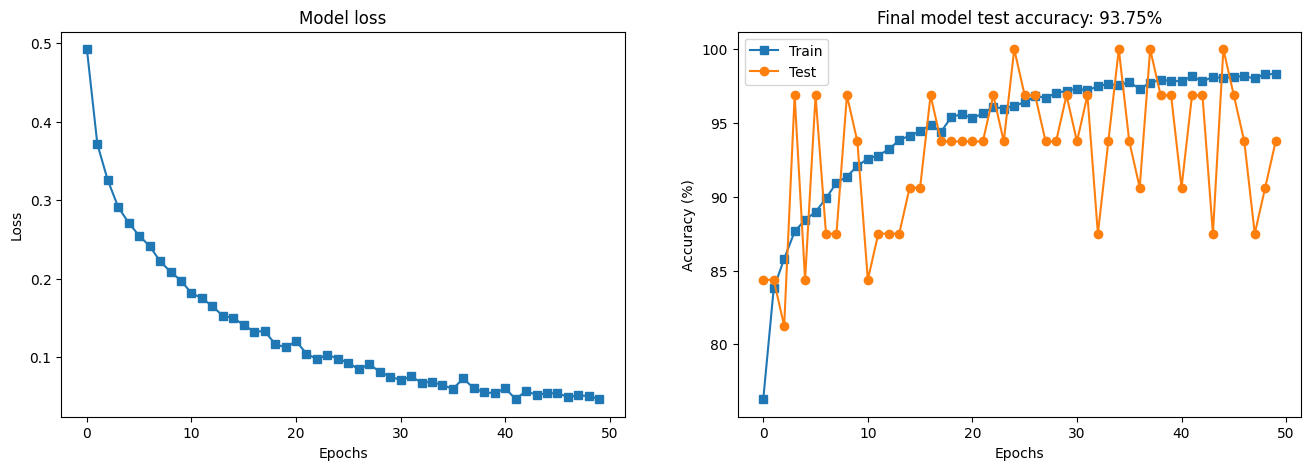

In [10]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()